# Dataset

We used the dataset  from Kaggle [Animal Species Classification - V3](https://www.kaggle.com/datasets/utkarshsaxenadn/animal-image-classification-dataset).
The authors created it to to have a data set for classifying animal species.
It is licensed under the "CC0: Public Domain" license.

The dataset comes already with a train, validation and test split for a total of 15 different animal classes.
The training data contains 2000 images per class with 256x256 pixels per picture.
The validation set contains 100/200 images per class
and the testing data is filled with a random number
of images per class.

Since the project requires to have atleast 500 images per class and that 30% should be locked for the test set, 
we will only use the data contained in the training set and split it ourselves.
In the following code segments we split the data to 0.3 test and 0.7 training data.
From the 0.8 training data we split it again to reserve data for validation.
We use a hardcoded seed to ensure the same shuffle.
The training was precleaned to only contain the data directories for the 10 classes used in this project.

In [1]:
# Import dependencies
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' #Workaround for kernel crash because multiple copies of the OpenMP runtime have been linked

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras import models
from tensorflow.keras import layers


In [2]:
#Set os env variable. Only required if not already set.
#This should point to the folder which contains the training data
os.environ["aiap_data_path"] = "C:/Users/mrcls/temp_dataset/animals/data"

In [3]:
data_path = os.environ["aiap_data_path"]
batch_size = 32 # the whole data will be split into a total of the amount of batches
img_height = 64 # The image will be resized when imported to this height
img_width = 64 # The image will be resized when imported to this width
img_channels = 3 #RGB
shuffle_seed = 1234 # The seed for the data shuffle
shuffle_enabled = True
test_data_ratio = 0.3
validation_data_ratio= 0.2
img_classes = [ #explicitly defined to avoid errors
    "Cow",
    "Dog",
    "Elephant",
    "Gorilla",
    "Hippo",
    "Lizard",
    "Monkey",
    "Panda",
    "Tiger",
    "Zebra"
    ]


In [4]:
#Load the data and split it to training & test
data = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, #directory where data is located
    class_names=img_classes, #pass in names of classes
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=shuffle_enabled, #shuffle the data
    seed=shuffle_seed, #seed for the shuffling and transformations
    validation_split=test_data_ratio, #we reserve a ratio of the data for the test set
    subset="both", #return both test & training set
)
print("do not confuse the output here. we explicitly use the validation data as test data and split the training data again for the validation data")

Found 20000 files belonging to 10 classes.
Using 14000 files for training.
Using 6000 files for validation.
do not confuse the output here. we explicitly use the validation data as test data and split the training data again for the validation data


In [5]:
# print information about the data
print("data variable contains:",len(data),"elements")
training_data= data[0]
test_data = data[1]
assert isinstance(training_data, tf.data.Dataset)
assert isinstance(test_data, tf.data.Dataset)
print("training data size:",training_data.cardinality())
print("test data size:", test_data.cardinality())
print("class names:", training_data.class_names)


data variable contains: 2 elements
training data size: tf.Tensor(438, shape=(), dtype=int64)
test data size: tf.Tensor(188, shape=(), dtype=int64)
class names: ['Cow', 'Dog', 'Elephant', 'Gorilla', 'Hippo', 'Lizard', 'Monkey', 'Panda', 'Tiger', 'Zebra']


In [6]:
# finally split the current training data into a separate validation set
training_data_size = sum(1 for _ in training_data)
print(training_data_size, "batches")
validation_data_size = int(validation_data_ratio * training_data_size)
print(validation_data_size, "batches")
validation_data = training_data.take(validation_data_size)
class_names = training_data.class_names
training_data = training_data.skip(validation_data_size)

438 batches
87 batches


## Normalize Data

In [7]:
# Print the shape of the input data
print("Shape of training data:")
i = 0
for x, y in training_data:
    print(x.shape)
    print(y.shape)
    print("True label:", y[0])
    i=i+1
    if i>3:
        break

Shape of training data:
(32, 64, 64, 3)
(32,)
True label: tf.Tensor(6, shape=(), dtype=int32)
(32, 64, 64, 3)
(32,)
True label: tf.Tensor(6, shape=(), dtype=int32)
(32, 64, 64, 3)
(32,)
True label: tf.Tensor(4, shape=(), dtype=int32)
(32, 64, 64, 3)
(32,)
True label: tf.Tensor(2, shape=(), dtype=int32)


In [8]:
def printPixelValueRange(dataset):
    for image, _ in dataset.take(1):
        print(f"Max value: {np.max(image[0])}")
printPixelValueRange(training_data)
printPixelValueRange(validation_data)
printPixelValueRange(test_data)

Max value: 255.0
Max value: 253.25
Max value: 254.25


In [9]:
def normalize(image,label):
    image = tf.cast(image/255.0 ,tf.float32)
    return image,label

training_data = training_data.map(normalize)
validation_data = validation_data.map(normalize)
test_data = test_data.map(normalize)


printPixelValueRange(training_data)
printPixelValueRange(validation_data)
printPixelValueRange(test_data)

Max value: 0.9960784316062927
Max value: 0.9941176176071167
Max value: 0.9970588088035583


## Data Class Distribution

In [62]:
# Initialize counters for each class
class_counts_training = {class_name: 0 for class_name in class_names}
class_counts_validation = {class_name: 0 for class_name in class_names}
class_counts_test = {class_name: 0 for class_name in class_names}

# Iterate through the dataset to count occurrences of each class
for batch in training_data:
    labels = batch[1]  # Assuming labels are in the second element of each batch
    for label in labels:
        class_counts_training[class_names[label]] += 1

for batch in validation_data:
    labels = batch[1]  # Assuming labels are in the second element of each batch
    for label in labels:
        class_counts_validation[class_names[label]] += 1

for batch in test_data:
    labels = batch[1]  # Assuming labels are in the second element of each batch
    for label in labels:
        class_counts_test[class_names[label]] += 1

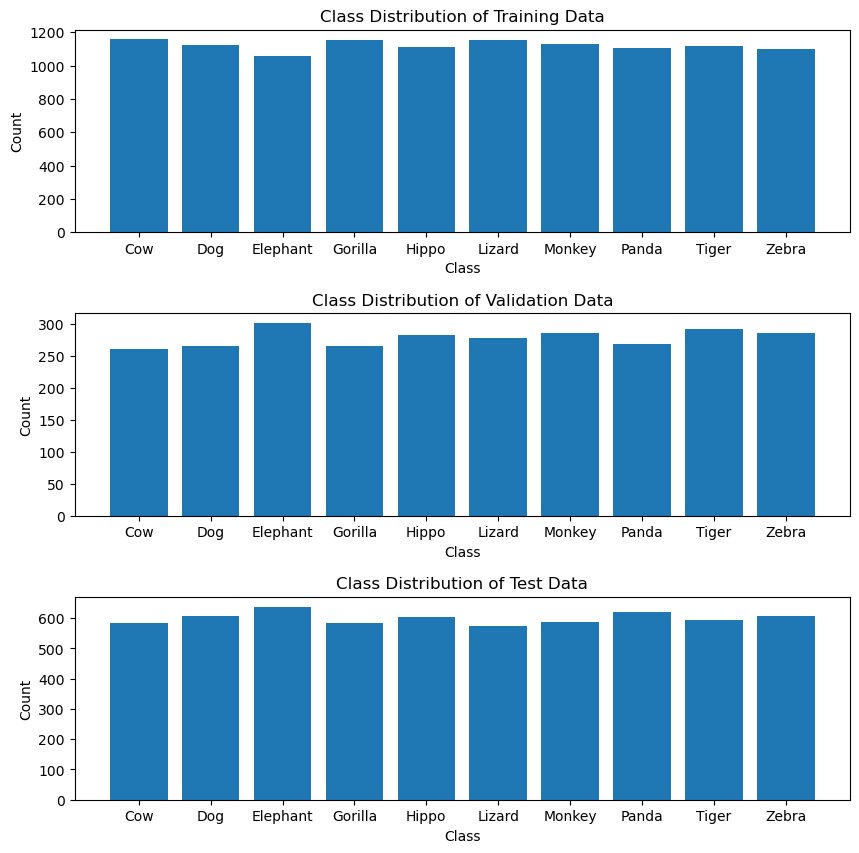

In [63]:

# Plot the class distribution
fig, (sub1, sub2, sub3) = plt.subplots(3, 1, figsize=(10, 10))
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

sub1.bar(class_counts_training.keys(), class_counts_training.values())
sub1.set_xlabel('Class')
sub1.set_ylabel('Count')
sub1.set_title('Class Distribution of Training Data')

sub2.bar(class_counts_validation.keys(), class_counts_validation.values())
sub2.set_xlabel('Class')
sub2.set_ylabel('Count')
sub2.set_title('Class Distribution of Validation Data')

sub3.bar(class_counts_test.keys(), class_counts_test.values())
sub3.set_xlabel('Class')
sub3.set_ylabel('Count')
sub3.set_title('Class Distribution of Test Data')
plt.show()

## Data Classes Plot

{'_input_dataset': <SkipDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>, '_use_inter_op_parallelism': True, '_preserve_cardinality': True, '_map_func': <tensorflow.python.data.ops.structured_function.StructuredFunctionWrapper object at 0x00000218AE2A2A10>, '_name': None, '_variant_tensor_attr': <tf.Tensor: shape=(), dtype=variant, value=<MapDatasetOp::Dataset>>, '_graph_attr': <tensorflow.python.framework.ops.Graph object at 0x000002188DAD90F0>, '_options_attr': <tensorflow.python.data.ops.options.Options object at 0x00000218AE2D93C0>}


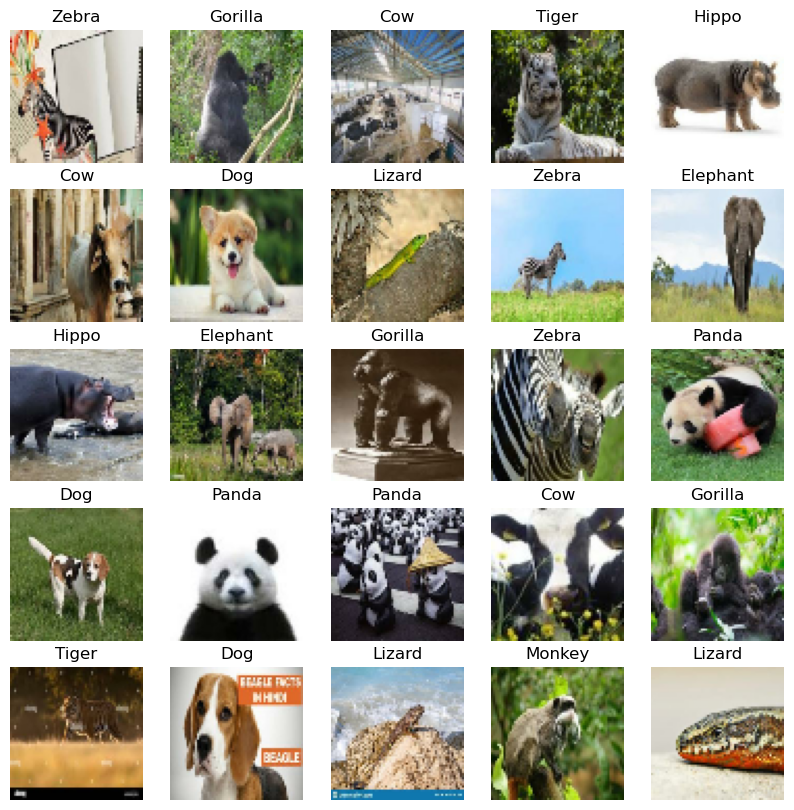

In [69]:
plt.figure(figsize=(10, 10))
print(vars(training_data))
for images, labels in training_data.take(1): # takes one batch
  for i in range(25):
    try:
      ax = plt.subplot(5, 5, i + 1)
      plt.imshow(images[i]) #.numpy().astype("uint8")
      plt.title(class_names[labels[i]])
      plt.axis("off")
    except Exception as e:
      print(f"Error at index {i}: {e}")

## Exploratory data analysis
The data set consists of low value images. As you can see from the visualization above, a lot of them include text, are computer generated images or have other objects within the image space. The classes are well represented, each class has the same amount of images. After splitting the images into different sets they are still well distributed, as can be seen from the Class Distribution graph above. It also shall be noted that we did not use the augmented dataset. 

# First Architecture (Undefitting)
For the undefitting model we used a simple architecture with one conv and two deep layers.
The architecture has 2282 parameters.

In [72]:
simple_model = models.Sequential()
simple_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, img_channels)))
simple_model.add(layers.MaxPooling2D((32, 32)))
simple_model.add(layers.Flatten())
simple_model.add(layers.Dense(32, activation='relu'))
simple_model.add(layers.Dense(10))
simple_model.summary()

Model: "sequential_6"
_________________________________________________________________


 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 1, 1, 32)         0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 32)                1056      
                                                                 
 dense_13 (Dense)            (None, 10)                330       
                                                                 
Total params: 2,282
Trainable params: 2,282
Non-trainable params: 0
_________________________________________________________________


In [73]:
simple_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [74]:
# history dictionary for successive combined trainings
combined_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

In [110]:
# save history data to disk
import json
# Save the dictionary to disk using JSON
with open('combined_history_simple_model.json', 'w') as f:
    json.dump(combined_history, f)

In [73]:
# load history data from disk
import json

with open('combined_history_simple_model.json', 'r') as f:
    combined_history = json.load(f)

In [75]:
# train
history = simple_model.fit(training_data, epochs=100, 
                           validation_data=validation_data)
# Update the combined_history with the first training session
for key in combined_history.keys():
    combined_history[key].extend(history.history[key])

Epoch 1/100


351/351 [==============================] - 5s 12ms/step - loss: 2.1898 - accuracy: 0.2123 - val_loss: 2.0294 - val_accuracy: 0.2942
Epoch 2/100
351/351 [==============================] - 5s 12ms/step - loss: 1.9433 - accuracy: 0.3119 - val_loss: 1.8775 - val_accuracy: 0.3261
Epoch 3/100
351/351 [==============================] - 5s 12ms/step - loss: 1.8449 - accuracy: 0.3468 - val_loss: 1.8122 - val_accuracy: 0.3495
Epoch 4/100
351/351 [==============================] - 5s 12ms/step - loss: 1.8019 - accuracy: 0.3590 - val_loss: 1.7990 - val_accuracy: 0.3470
Epoch 5/100
351/351 [==============================] - 5s 12ms/step - loss: 1.7741 - accuracy: 0.3724 - val_loss: 1.7553 - val_accuracy: 0.3757
Epoch 6/100
351/351 [==============================] - 5s 13ms/step - loss: 1.7554 - accuracy: 0.3814 - val_loss: 1.7430 - val_accuracy: 0.3879
Epoch 7/100
351/351 [==============================] - 5s 14ms/step - loss: 1.7389 - accuracy: 0.3849 - val_loss: 1.7425 - val_accuracy: 0.3757
Epoc

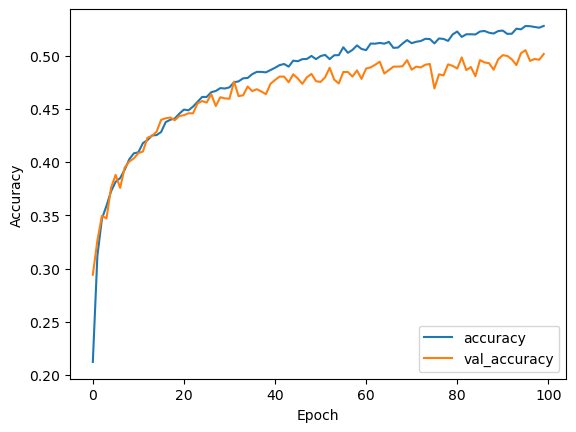

In [77]:
# plott accuracy
plt.plot(combined_history['accuracy'], label='accuracy')
plt.plot(combined_history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

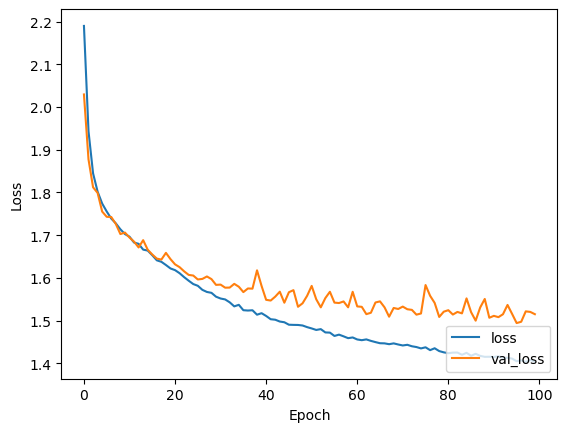

In [78]:
# plot error
plt.plot(combined_history['loss'], label = 'loss')
plt.plot(combined_history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [79]:
print("validation data",simple_model.evaluate(training_data))
print("validation data",simple_model.evaluate(validation_data))

351/351 [==============================] - 2s 5ms/step - loss: 1.4045 - accuracy: 0.5280
validation data [1.404481053352356, 0.5279957056045532]
87/87 [==============================] - 1s 5ms/step - loss: 1.5086 - accuracy: 0.5040
validation data [1.508561372756958, 0.5039511322975159]


## Helper Functions

In [109]:
# save model to disk
simple_model.save("simple_model")

INFO:tensorflow:Assets written to: simple_model\assets


INFO:tensorflow:Assets written to: simple_model\assets


In [133]:
simple_model = tf.keras.models.load_model('simple_model')

## Confusion Matrix


In [134]:
predicted_labels = np.array([])
true_labels = np.array([])

for x, y in training_data:
    predicted_labels = np.concatenate([predicted_labels,
                       np.argmax(simple_model(x), axis=-1)])
    true_labels = np.concatenate([true_labels, y])



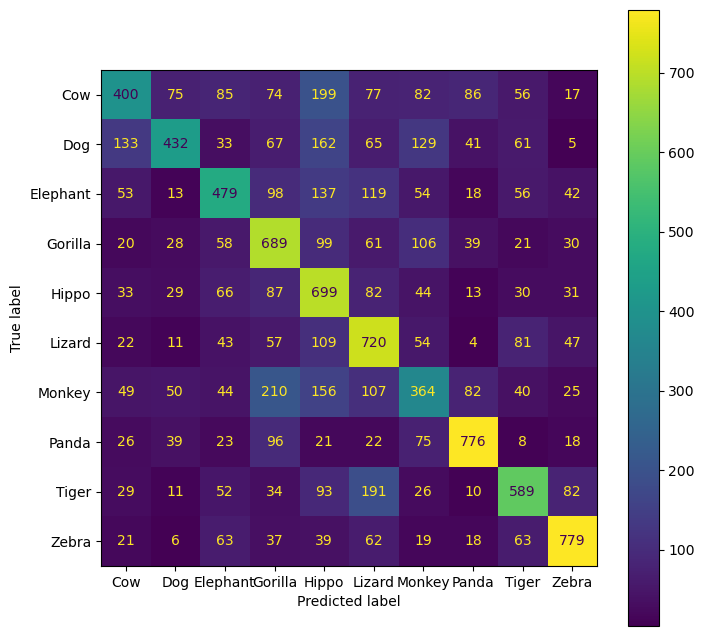

In [135]:
#predictions = simple_model.predict(training_data)
#predicted_labels = np.argmax(predictions, axis=1) 
#true_labels = np.concatenate([y.numpy() for _, y in training_data], axis=0) 
cm = confusion_matrix(true_labels, predicted_labels) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

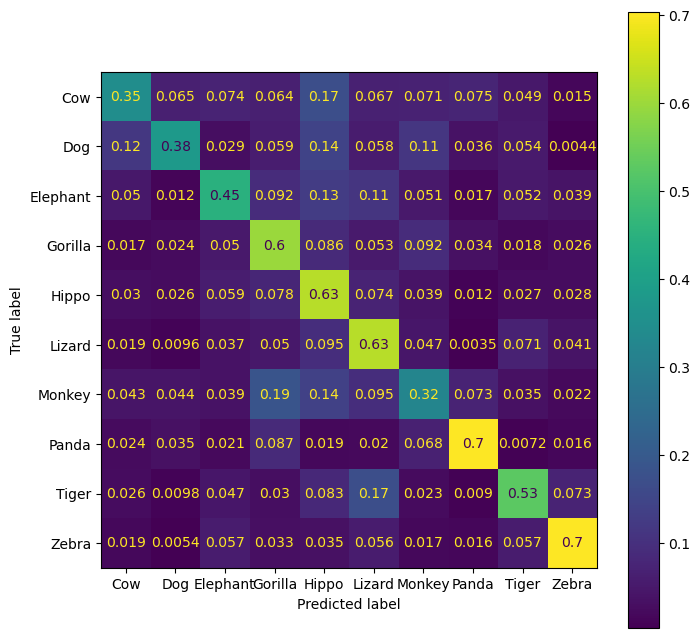

In [136]:
cm = confusion_matrix(true_labels, predicted_labels, normalize='true') 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

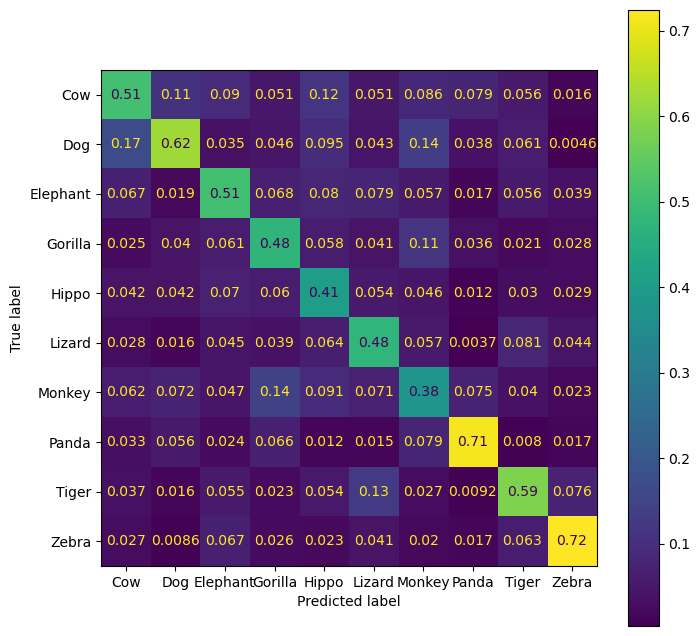

In [137]:
cm = confusion_matrix(true_labels, predicted_labels, normalize='pred') 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

## Performance Discussion
As one can see from the plots, the model performance settles at around 0.52 training and 0.5 validation accuracy after training it during 100 epochs. The model is to simple to create better predictions. At about 20 epochs further training has noticable less impact on accuracy and loss.

The confusion matrix 

# Second Architecture (Overfitting)

In [100]:
#Notes:
#https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7
#If you think that a big amount of pixels are necessary for the network to recognize the object you will use large filters (as 11x11 or 9x9). 
#If you think what differentiates objects are some small and local features you should use small filters (3x3 or 5x5)
# Note in general we use filters with odd sizes.
#The basic principle followed in building a convolutional neural network is 
#to ‘keep the feature space wide and shallow in the initial stages of the network, and the make it narrower and deeper towards the end.’
#Always start by using smaller filters is to collect as much local information as possible, and then gradually 
#increase the filter width to reduce the generated feature space width to represent more global, high-level and representative information
# By convention the number of channels generally increase or stay the same while we progress through layers in our convolutional neural net architecture
# Keep adding layers until you over-fit. 
#As once we achieved a considerable accuracy in our validation set we can use 
#regularization components like l1/l2 regularization, dropout, batch norm, data augmentation etc. to reduce over-fitting
#https://medium.com/@charlottecullip/a-comparison-of-cnn-architectures-part-2-8d03c67d8ec6
#https://www.geeksforgeeks.org/convolutional-neural-network-cnn-architectures/
#https://medium.com/@sajals1146/alexnet-architecture-993b760dec86

complex_model = models.Sequential()
# first
complex_model.add(layers.Conv2D(96, (6, 6),strides=2, activation='relu', input_shape=(img_height, img_width, img_channels)))
complex_model.add(layers.BatchNormalization())
# second
complex_model.add(layers.Conv2D(128, (5, 5), padding='same', activation='relu'))
complex_model.add(layers.BatchNormalization())
# third
complex_model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
complex_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
complex_model.add(layers.BatchNormalization())
#fourth
complex_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
complex_model.add(layers.BatchNormalization())
#fifth
complex_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
complex_model.add(layers.BatchNormalization())
complex_model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
#deep
complex_model.add(layers.Flatten())
complex_model.add(layers.Dense(512, activation='relu'))
complex_model.add(layers.BatchNormalization())
complex_model.add(layers.Dense(256, activation='relu'))
complex_model.add(layers.BatchNormalization())
complex_model.add(layers.Dense(10))
complex_model.summary()


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_110 (Conv2D)         (None, 30, 30, 96)        10464     
                                                                 
 batch_normalization_154 (Ba  (None, 30, 30, 96)       384       
 tchNormalization)                                               
                                                                 
 conv2d_111 (Conv2D)         (None, 30, 30, 128)       307328    
                                                                 
 batch_normalization_155 (Ba  (None, 30, 30, 128)      512       
 tchNormalization)                                               
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                     

In [56]:
complex_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [57]:
# history dictionary for successive combined trainings
combined_complex_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

In [71]:
# save history data to disk for later use
import json
# Save the dictionary to disk using JSON
with open('combined_history_complex_model.json', 'w') as f:
    json.dump(combined_complex_history, f)

In [45]:
# load history data from disk
import json

with open('combined_history_complex_model.json', 'r') as f:
    combined_complex_history = json.load(f)

In [58]:
# train
history = complex_model.fit(training_data, epochs=50, 
                           validation_data=validation_data)
# Update the combined_history with the first training session
for key in combined_complex_history.keys():
    combined_complex_history[key].extend(history.history[key])

Epoch 1/50


351/351 [==============================] - 123s 338ms/step - loss: 1.7893 - accuracy: 0.3971 - val_loss: 2.7146 - val_accuracy: 0.2019
Epoch 2/50
351/351 [==============================] - 104s 294ms/step - loss: 1.3770 - accuracy: 0.5341 - val_loss: 2.1993 - val_accuracy: 0.3373
Epoch 3/50
351/351 [==============================] - 104s 294ms/step - loss: 1.1610 - accuracy: 0.6049 - val_loss: 2.4793 - val_accuracy: 0.3208
Epoch 4/50
351/351 [==============================] - 105s 297ms/step - loss: 1.0226 - accuracy: 0.6538 - val_loss: 1.9761 - val_accuracy: 0.4846
Epoch 5/50
351/351 [==============================] - 104s 296ms/step - loss: 0.9077 - accuracy: 0.6957 - val_loss: 1.3277 - val_accuracy: 0.5754
Epoch 6/50
351/351 [==============================] - 102s 289ms/step - loss: 0.8096 - accuracy: 0.7268 - val_loss: 1.4715 - val_accuracy: 0.5471
Epoch 7/50
351/351 [==============================] - 101s 286ms/step - loss: 0.7291 - accuracy: 0.7550 - val_loss: 3.5819 - val_accura

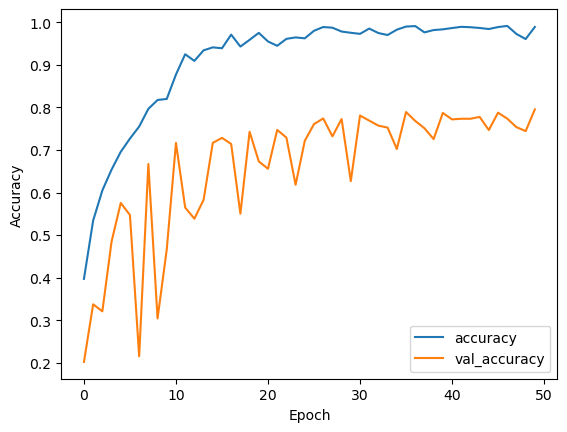

In [101]:
# plott accuracy
plt.plot(combined_complex_history['accuracy'], label='accuracy')
plt.plot(combined_complex_history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

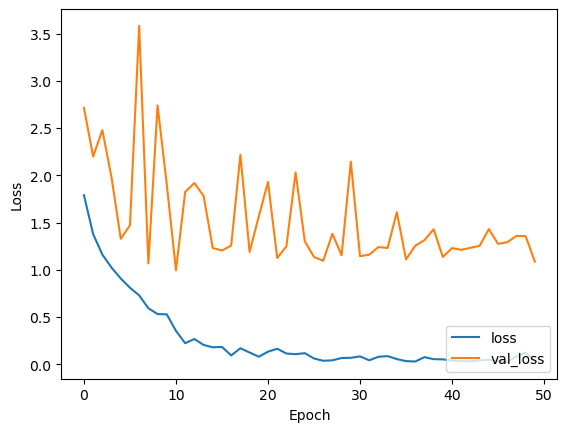

In [102]:
# plot error
plt.plot(combined_complex_history['loss'], label = 'loss')
plt.plot(combined_complex_history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [62]:
print("validation data",complex_model.evaluate(training_data))
print("validation data",complex_model.evaluate(validation_data))

351/351 [==============================] - 55s 154ms/step - loss: 0.0067 - accuracy: 0.9979
validation data [0.0067480928264558315, 0.9979493618011475]
87/87 [==============================] - 13s 151ms/step - loss: 1.0777 - accuracy: 0.7967
validation data [1.0776903629302979, 0.7966954112052917]


In [63]:
# save model to disk
complex_model.save("complex_model")

INFO:tensorflow:Assets written to: complex_model\assets


INFO:tensorflow:Assets written to: complex_model\assets


In [49]:
complex_model = tf.keras.models.load_model('complex_model')

## Confusion Matrix

In [65]:
predicted_labels = np.array([])
true_labels = np.array([])

for x, y in training_data:
    predicted_labels = np.concatenate([predicted_labels,
                       np.argmax(complex_model(x), axis=-1)])
    true_labels = np.concatenate([true_labels, y])



In [66]:
print(true_labels)
print(predicted_labels)

[2. 4. 8. ... 4. 1. 4.]
[2. 4. 8. ... 4. 1. 4.]


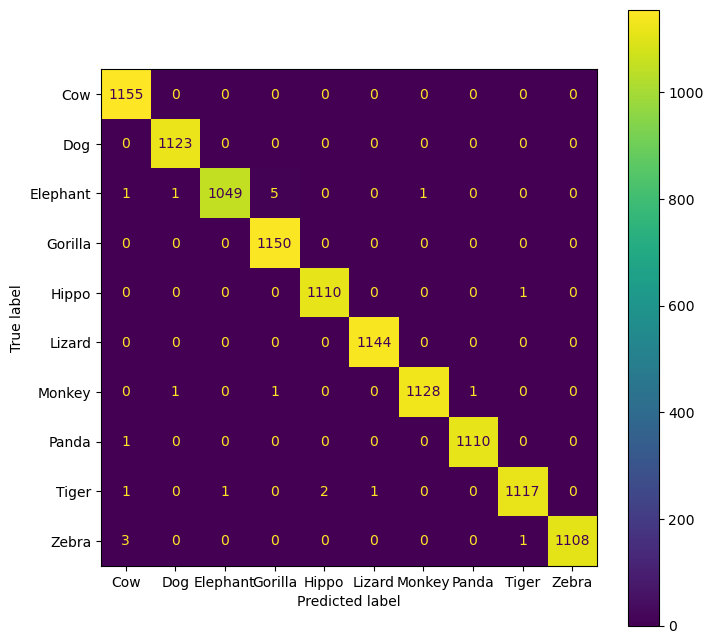

In [67]:
# ATTENTION: You cannot run the code like below (commented out),
# since tensorflow will reshuffle the data so that true and predictions do not match anymore!
#predicted_labels = np.argmax(predictions, axis=-1) 
#print(predicted_labels)
#true_labels = np.concatenate([y.numpy() for _, y in training_data], axis=0) 
#print(true_labels)
cm = confusion_matrix(true_labels,predicted_labels) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

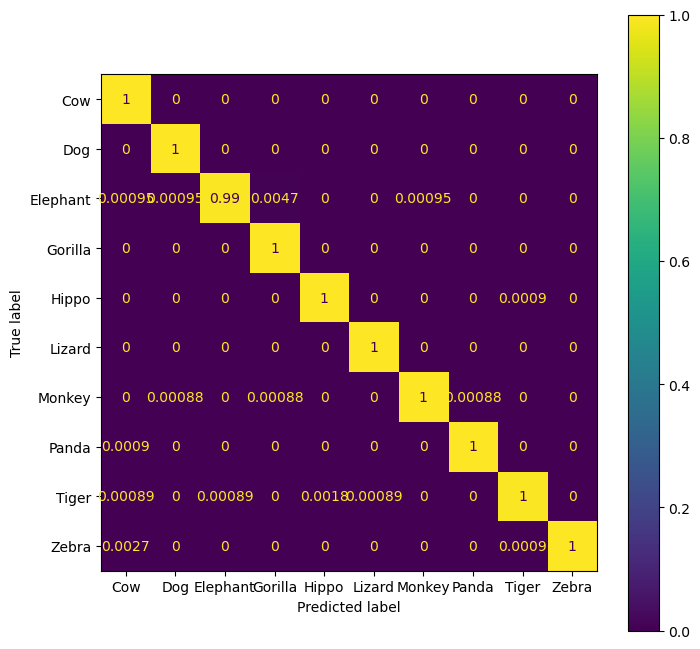

In [68]:
cm = confusion_matrix(true_labels, predicted_labels, normalize='true') 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

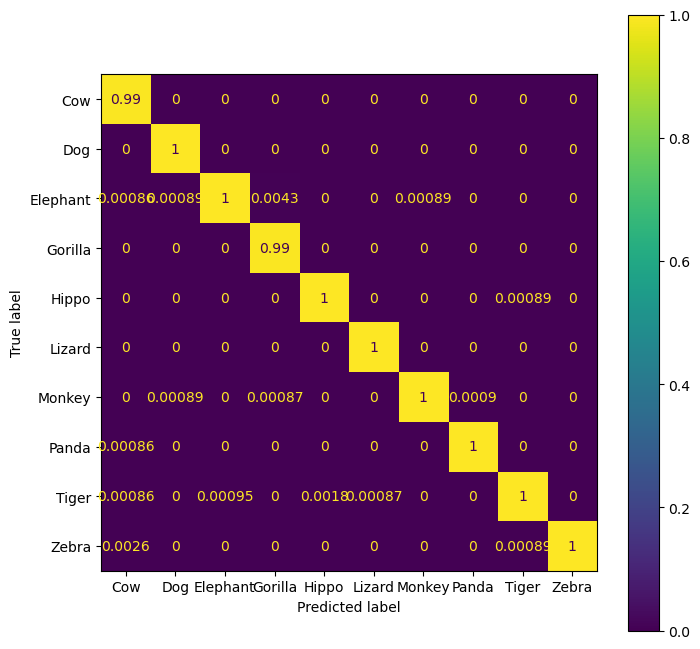

In [69]:
cm = confusion_matrix(true_labels, predicted_labels, normalize='pred') 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

## Performance Discussion

# Third Architecture (Regularized)

In [15]:
# save history data to disk
import json

drop_parms = [0.1, 0.5]
l2_parms = [0.000001, 0.001, 1, 1000]

# history dictionary for successive combined trainings
all_histories = {}

for drop_rate in drop_parms:
    for l2_value in l2_parms:
        
        complex_opt_model = models.Sequential()
        # first
        complex_opt_model.add(layers.Conv2D(96, (6, 6),strides=2, activation='relu' , kernel_regularizer=tf.keras.regularizers.l2(l2_value), input_shape=(img_height, img_width, img_channels)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.Dropout(drop_rate))

        # second
        complex_opt_model.add(layers.Conv2D(128, (5, 5), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_value)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.Dropout(drop_rate))
        # third
        complex_opt_model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
        complex_opt_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_value)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.Dropout(drop_rate))
        #fourth
        complex_opt_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_value)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.Dropout(drop_rate))
        #fifth
        complex_opt_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_value)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
        complex_opt_model.add(layers.Dropout(drop_rate))
        #deep
        complex_opt_model.add(layers.Flatten())
        complex_opt_model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_value)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.Dropout(drop_rate))
        complex_opt_model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_value)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.Dropout(drop_rate))
        complex_opt_model.add(layers.Dense(10))
        complex_opt_model.summary()

        complex_opt_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
        
        # train 15 epochs with different values of regularization
        # dropout 0.1 and 0.5
        # 10-6 to 10-3
        history = complex_opt_model.fit(training_data, epochs=15, 
                                validation_data=validation_data)

        # Store training history
        all_histories[str(drop_rate)+"_"+str(l2_value)] = history.history
        
        # Save the dictionary to disk using JSON
        with open('optimized_model_all_history.json', 'w') as f:
            json.dump(all_histories, f)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 30, 30, 96)        10464     
                                                                 
 batch_normalization_21 (Bat  (None, 30, 30, 96)       384       
 chNormalization)                                                
                                                                 
 dropout_21 (Dropout)        (None, 30, 30, 96)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 30, 30, 128)       307328    
                                                                 
 batch_normalization_22 (Bat  (None, 30, 30, 128)      512       
 chNormalization)                                                
                                                                 
 dropout_22 (Dropout)        (None, 30, 30, 128)      

ValueError: in user code:

    File "c:\ProgramData\anaconda3\envs\cnn\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\ProgramData\anaconda3\envs\cnn\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\anaconda3\envs\cnn\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\ProgramData\anaconda3\envs\cnn\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\ProgramData\anaconda3\envs\cnn\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "dropout_77" "                 f"(type Dropout).
    
    `rate` must be a scalar tensor or a float in the range [0, 1). Received: rate=1
    
    Call arguments received by layer "dropout_77" "                 f"(type Dropout):
      • inputs=tf.Tensor(shape=(None, 30, 30, 96), dtype=float32)
      • training=True


In [85]:
# load history data from disk
import json

with open('optimized_model_all_history.json', 'r') as f:
    all_histories = json.load(f)

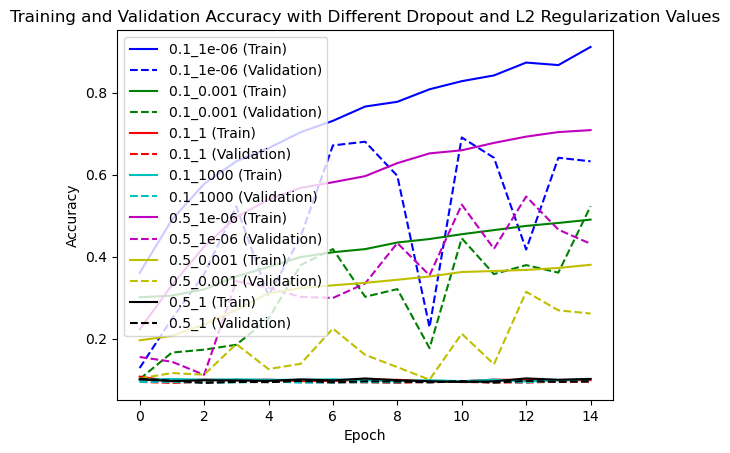

In [86]:
# Define colors for plotting
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Plot training and validation accuracy
for i, (key, color) in enumerate(zip(all_histories.keys(), colors)):
    history = all_histories[key]
    plt.plot(history['accuracy'], label=key + ' (Train)', color=color)
    plt.plot(history['val_accuracy'], label=key + ' (Validation)', color=color, linestyle='--')  # Dashed line for validation accuracy
#plt.plot(combined_complex_history['accuracy'], label='Original (Train)',color='black')
#plt.plot(combined_complex_history['val_accuracy'], label='Original (Validation)', color='black', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy with Different Dropout and L2 Regularization Values')
plt.legend()
plt.show()

 take blue or green because it has highest validation? 

In [19]:
import json

drop_parms = [0.1]
l2_parms = [0.0000001 ,0.000001, 0.00001, 0.0001]

# history dictionary for successive combined trainings
all_histories_2 = {}

for drop_rate in drop_parms:
    for l2_value in l2_parms:
        
        complex_opt_model = models.Sequential()
        # first
        complex_opt_model.add(layers.Conv2D(96, (6, 6),strides=2, activation='relu' , kernel_regularizer=tf.keras.regularizers.l2(l2_value), input_shape=(img_height, img_width, img_channels)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.Dropout(drop_rate))

        # second
        complex_opt_model.add(layers.Conv2D(128, (5, 5), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_value)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.Dropout(drop_rate))
        # third
        complex_opt_model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
        complex_opt_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_value)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.Dropout(drop_rate))
        #fourth
        complex_opt_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_value)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.Dropout(drop_rate))
        #fifth
        complex_opt_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_value)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
        complex_opt_model.add(layers.Dropout(drop_rate))
        #deep
        complex_opt_model.add(layers.Flatten())
        complex_opt_model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_value)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.Dropout(drop_rate))
        complex_opt_model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_value)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.Dropout(drop_rate))
        complex_opt_model.add(layers.Dense(10))
        complex_opt_model.summary()

        complex_opt_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
        
        # train 15 epochs with different values of regularization
        # dropout 0.1 and 0.5
        # 10-6 to 10-3
        history = complex_opt_model.fit(training_data, epochs=15, 
                                validation_data=validation_data)

        # Store training history
        all_histories_2[str(drop_rate)+"_"+str(l2_value)] = history.history
        
        # Save the dictionary to disk using JSON
        with open('optimized_model_all_history_2.json', 'w') as f:
            json.dump(all_histories_2, f)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 30, 30, 96)        10464     
                                                                 
 batch_normalization_84 (Bat  (None, 30, 30, 96)       384       
 chNormalization)                                                
                                                                 
 dropout_84 (Dropout)        (None, 30, 30, 96)        0         
                                                                 
 conv2d_61 (Conv2D)          (None, 30, 30, 128)       307328    
                                                                 
 batch_normalization_85 (Bat  (None, 30, 30, 128)      512       
 chNormalization)                                                
                                                                 
 dropout_85 (Dropout)        (None, 30, 30, 128)     

In [79]:
# load history data from disk
import json

with open('optimized_model_all_history_2.json', 'r') as f:
    all_histories_2 = json.load(f)

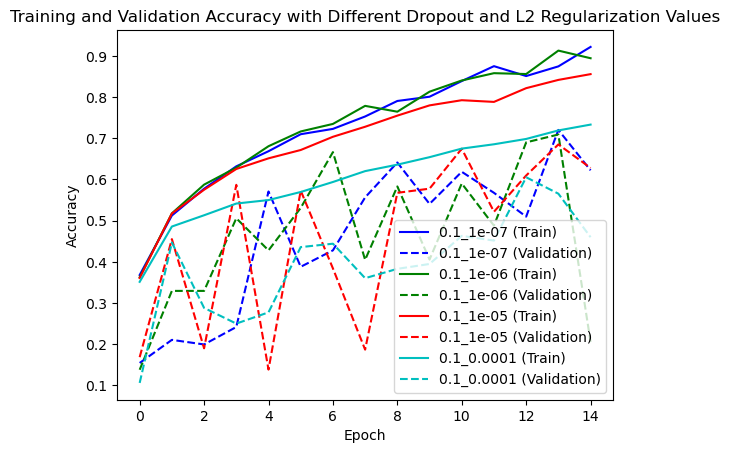

In [82]:
# Define colors for plotting
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Plot training and validation accuracy
for i, (key, color) in enumerate(zip(all_histories_2.keys(), colors)):
    history = all_histories_2[key]
    plt.plot(history['accuracy'], label=key + ' (Train)', color=color)
    plt.plot(history['val_accuracy'], label=key + ' (Validation)', color=color, linestyle='--')  # Dashed line for validation accuracy
#plt.plot(combined_complex_history['accuracy'], label='Original (Train)',color='black')
#plt.plot(combined_complex_history['val_accuracy'], label='Original (Validation)', color='black', linestyle='--')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy with Different Dropout and L2 Regularization Values')
plt.legend()
plt.show()

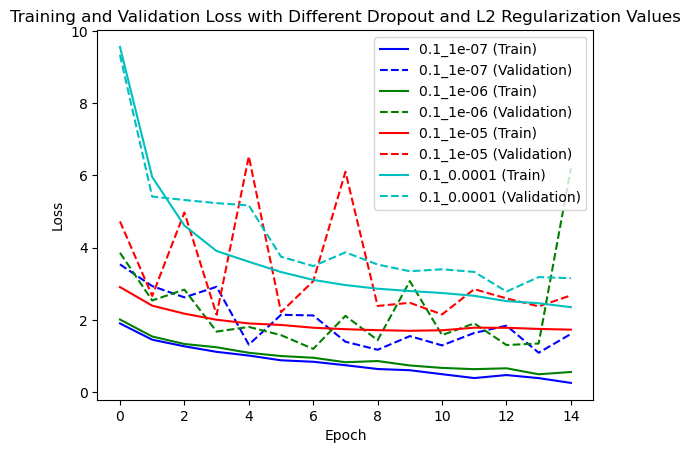

In [84]:
# Define colors for plotting
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Plot training and validation accuracy
for i, (key, color) in enumerate(zip(all_histories_2.keys(), colors)):
    history = all_histories_2[key]
    plt.plot(history['loss'], label=key + ' (Train)', color=color)
    plt.plot(history['val_loss'], label=key + ' (Validation)', color=color, linestyle='--')  # Dashed line for validation accuracy
#plt.plot(combined_complex_history['loss'], label='Original (Train)',color='black')
#plt.plot(combined_complex_history['val_loss'], label='Original (Validation)', color='black', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with Different Dropout and L2 Regularization Values')
plt.legend()
plt.show()

In [27]:
# save history data to disk
import json

drop_parms = [0.005,0.1, 0.015]
l2_parms = [0.0000001]

# history dictionary for successive combined trainings
all_histories_3 = {}

for drop_rate in drop_parms:
    for l2_value in l2_parms:
        
        complex_opt_model = models.Sequential()
        # first
        complex_opt_model.add(layers.Conv2D(96, (6, 6),strides=2, activation='relu' , kernel_regularizer=tf.keras.regularizers.l2(l2_value), input_shape=(img_height, img_width, img_channels)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.Dropout(drop_rate))

        # second
        complex_opt_model.add(layers.Conv2D(128, (5, 5), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_value)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.Dropout(drop_rate))
        # third
        complex_opt_model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
        complex_opt_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_value)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.Dropout(drop_rate))
        #fourth
        complex_opt_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_value)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.Dropout(drop_rate))
        #fifth
        complex_opt_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_value)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
        complex_opt_model.add(layers.Dropout(drop_rate))
        #deep
        complex_opt_model.add(layers.Flatten())
        complex_opt_model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_value)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.Dropout(drop_rate))
        complex_opt_model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_value)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.Dropout(drop_rate))
        complex_opt_model.add(layers.Dense(10))
        complex_opt_model.summary()

        complex_opt_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
        
        # train 15 epochs with different values of regularization
        # dropout 0.1 and 0.5
        # 10-6 to 10-3
        history = complex_opt_model.fit(training_data, epochs=15, 
                                validation_data=validation_data)

        # Store training history
        all_histories_3[str(drop_rate)+"_"+str(l2_value)] = history.history
        
        # Save the dictionary to disk using JSON
        with open('optimized_model_all_history_3.json', 'w') as f:
            json.dump(all_histories, f)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_80 (Conv2D)          (None, 30, 30, 96)        10464     
                                                                 
 batch_normalization_112 (Ba  (None, 30, 30, 96)       384       
 tchNormalization)                                               
                                                                 
 dropout_112 (Dropout)       (None, 30, 30, 96)        0         
                                                                 
 conv2d_81 (Conv2D)          (None, 30, 30, 128)       307328    
                                                                 
 batch_normalization_113 (Ba  (None, 30, 30, 128)      512       
 tchNormalization)                                               
                                                                 
 dropout_113 (Dropout)       (None, 30, 30, 128)     

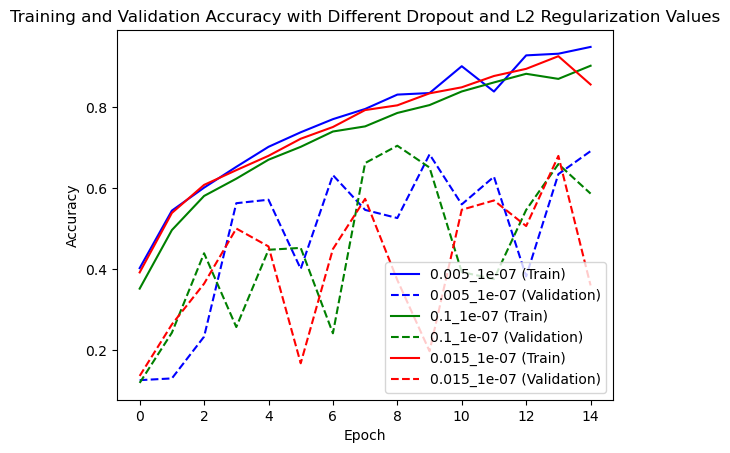

In [87]:
# Define colors for plotting
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Plot training and validation accuracy
for i, (key, color) in enumerate(zip(all_histories_3.keys(), colors)):
    history = all_histories_3[key]
    plt.plot(history['accuracy'], label=key + ' (Train)', color=color)
    plt.plot(history['val_accuracy'], label=key + ' (Validation)', color=color, linestyle='--')  # Dashed line for validation accuracy

#plt.plot(combined_complex_history['accuracy'], label='Original (Train)',color='black')
#plt.plot(combined_complex_history['val_accuracy'], label='Original (Validation)', color='black', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy with Different Dropout and L2 Regularization Values')
plt.legend()
plt.show()

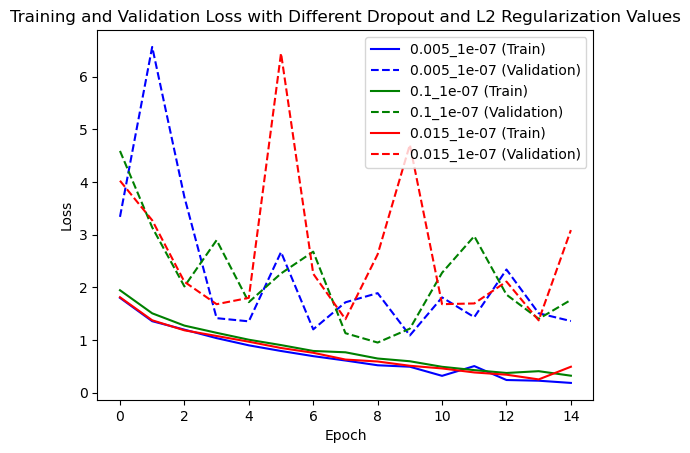

In [88]:
# Define colors for plotting
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Plot training and validation accuracy
for i, (key, color) in enumerate(zip(all_histories_3.keys(), colors)):
    history = all_histories_3[key]
    plt.plot(history['loss'], label=key + ' (Train)', color=color)
    plt.plot(history['val_loss'], label=key + ' (Validation)', color=color, linestyle='--')  # Dashed line for validation accuracy
#plt.plot(combined_complex_history['loss'], label='Original (Train)',color='black')
#plt.plot(combined_complex_history['val_loss'], label='Original (Validation)', color='black', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with Different Dropout and L2 Regularization Values')
plt.legend()
plt.show()

In [93]:
# save history data to disk
import json

final_drop_rate = 0.005
final_l2_value = 0.0000001
        
complex_opt_model = models.Sequential()
# first
complex_opt_model.add(layers.Conv2D(96, (6, 6),strides=2, activation='relu' , kernel_regularizer=tf.keras.regularizers.l2(final_l2_value), input_shape=(img_height, img_width, img_channels)))
complex_opt_model.add(layers.BatchNormalization())
complex_opt_model.add(layers.Dropout(final_drop_rate))

# second
complex_opt_model.add(layers.Conv2D(128, (5, 5), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(final_l2_value)))
complex_opt_model.add(layers.BatchNormalization())
complex_opt_model.add(layers.Dropout(final_drop_rate))
# third
complex_opt_model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
complex_opt_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(final_l2_value)))
complex_opt_model.add(layers.BatchNormalization())
complex_opt_model.add(layers.Dropout(final_drop_rate))
#fourth
complex_opt_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(final_l2_value)))
complex_opt_model.add(layers.BatchNormalization())
complex_opt_model.add(layers.Dropout(final_drop_rate))
#fifth
complex_opt_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(final_l2_value)))
complex_opt_model.add(layers.BatchNormalization())
complex_opt_model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
complex_opt_model.add(layers.Dropout(final_drop_rate))
#deep
complex_opt_model.add(layers.Flatten())
complex_opt_model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(final_l2_value)))
complex_opt_model.add(layers.BatchNormalization())
complex_opt_model.add(layers.Dropout(final_drop_rate))
complex_opt_model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(final_l2_value)))
complex_opt_model.add(layers.BatchNormalization())
complex_opt_model.add(layers.Dropout(final_drop_rate))
complex_opt_model.add(layers.Dense(10))
complex_opt_model.summary()

complex_opt_model.compile(optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_105 (Conv2D)         (None, 30, 30, 96)        10464     
                                                                 
 batch_normalization_147 (Ba  (None, 30, 30, 96)       384       
 tchNormalization)                                               
                                                                 
 dropout_140 (Dropout)       (None, 30, 30, 96)        0         
                                                                 
 conv2d_106 (Conv2D)         (None, 30, 30, 128)       307328    
                                                                 
 batch_normalization_148 (Ba  (None, 30, 30, 128)      512       
 tchNormalization)                                               
                                                                 
 dropout_141 (Dropout)       (None, 30, 30, 128)     

In [94]:
# history dictionary for successive combined trainings
combined_complex_opt_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

In [97]:
# save history data to disk
import json
# Save the dictionary to disk using JSON
with open('optimized_model.json', 'w') as f:
    json.dump(combined_complex_opt_history, f)

In [ ]:
# load history data from disk
import json

with open('optimized_model.json', 'r') as f:
    combined_complex_opt_history = json.load(f)

In [95]:
# train
history = complex_opt_model.fit(training_data, epochs=50, 
                           validation_data=validation_data)
# Update the combined_history with the first training session
for key in combined_complex_opt_history.keys():
    combined_complex_opt_history[key].extend(history.history[key])

Epoch 1/50


351/351 [==============================] - 137s 379ms/step - loss: 1.8433 - accuracy: 0.3730 - val_loss: 8.7048 - val_accuracy: 0.1013
Epoch 2/50
351/351 [==============================] - 122s 345ms/step - loss: 1.4085 - accuracy: 0.5252 - val_loss: 1.8696 - val_accuracy: 0.4052
Epoch 3/50
351/351 [==============================] - 122s 347ms/step - loss: 1.1830 - accuracy: 0.5988 - val_loss: 4.3608 - val_accuracy: 0.1293
Epoch 4/50
351/351 [==============================] - 123s 348ms/step - loss: 1.0618 - accuracy: 0.6476 - val_loss: 2.5159 - val_accuracy: 0.3477
Epoch 5/50
351/351 [==============================] - 123s 348ms/step - loss: 0.9152 - accuracy: 0.6970 - val_loss: 1.7013 - val_accuracy: 0.4641
Epoch 6/50
351/351 [==============================] - 122s 347ms/step - loss: 0.8291 - accuracy: 0.7248 - val_loss: 1.3800 - val_accuracy: 0.5496
Epoch 7/50
351/351 [==============================] - 123s 349ms/step - loss: 0.6839 - accuracy: 0.7708 - val_loss: 2.0847 - val_accura

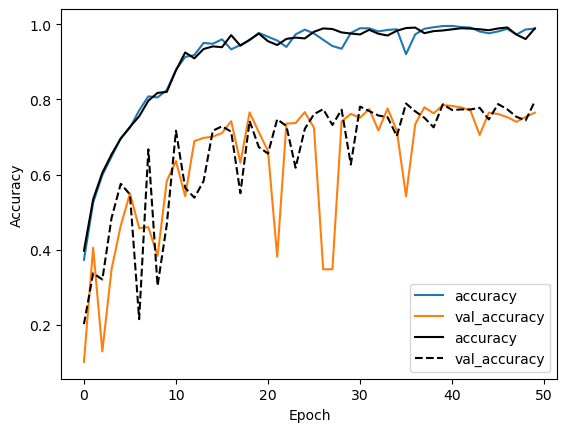

In [96]:
# plott accuracy
plt.plot(combined_complex_opt_history['accuracy'], label='accuracy')
plt.plot(combined_complex_opt_history['val_accuracy'], label = 'val_accuracy')
plt.plot(combined_complex_history['accuracy'], label='accuracy', color='black')
plt.plot(combined_complex_history['val_accuracy'], label = 'val_accuracy', color='black', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

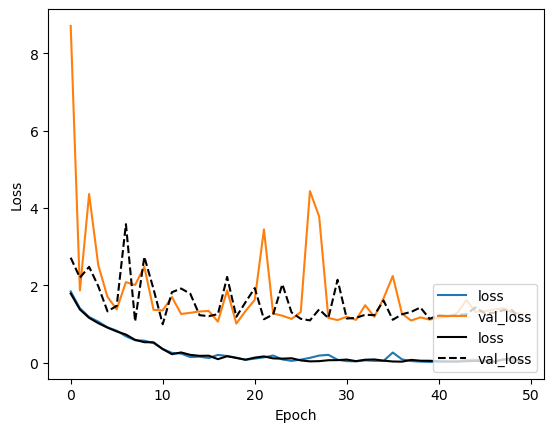

In [98]:
# plot error
plt.plot(combined_complex_opt_history['loss'], label = 'loss')
plt.plot(combined_complex_opt_history['val_loss'], label='val_loss')
plt.plot(combined_complex_history['loss'], label = 'loss', color='black')
plt.plot(combined_complex_history['val_loss'], label='val_loss', color='black', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [54]:
print("2, validation data",complex_opt_model.evaluate(training_data))
print("2, validation data",complex_opt_model.evaluate(validation_data))


351/351 [==============================] - 70s 197ms/step - loss: 0.1144 - accuracy: 0.9798
2, validation data [0.11435364186763763, 0.9797610640525818]
87/87 [==============================] - 36s 409ms/step - loss: 1.4465 - accuracy: 0.7504
2, validation data [1.4464832544326782, 0.7503591775894165]


In [ ]:
train_predictions = complex_opt_model.predict(training_data)
valid_predictions = complex_opt_model.predict(validation_data)

In [99]:
# save model to disk
complex_opt_model.save("optimized_model")

INFO:tensorflow:Assets written to: optimized_model\assets


INFO:tensorflow:Assets written to: optimized_model\assets


In [ ]:
complex_opt_model = tf.keras.models.load_model('optimized_model')

## Confusion Matrix

In [103]:
predicted_labels_co = np.array([])
true_labels_co = np.array([])

for x, y in training_data:
    predicted_labels_co = np.concatenate([predicted_labels_co,
                       np.argmax(complex_opt_model(x), axis=-1)])
    true_labels_co = np.concatenate([true_labels_co, y])

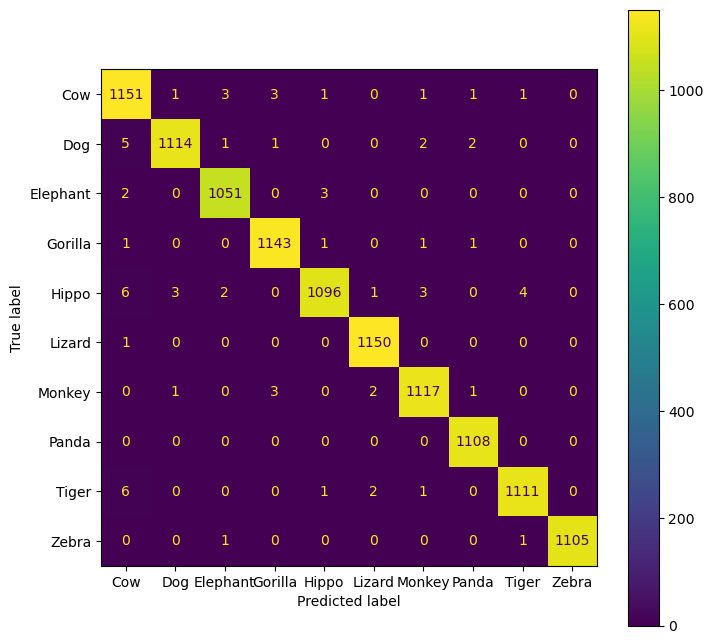

In [104]:
cm = confusion_matrix(true_labels_co,predicted_labels_co) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

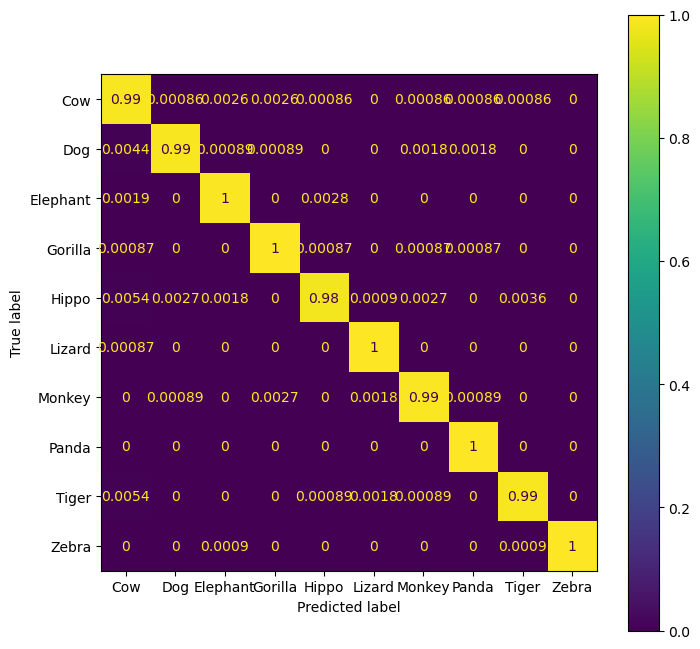

In [106]:
cm = confusion_matrix(true_labels_co, predicted_labels_co, normalize='true') 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

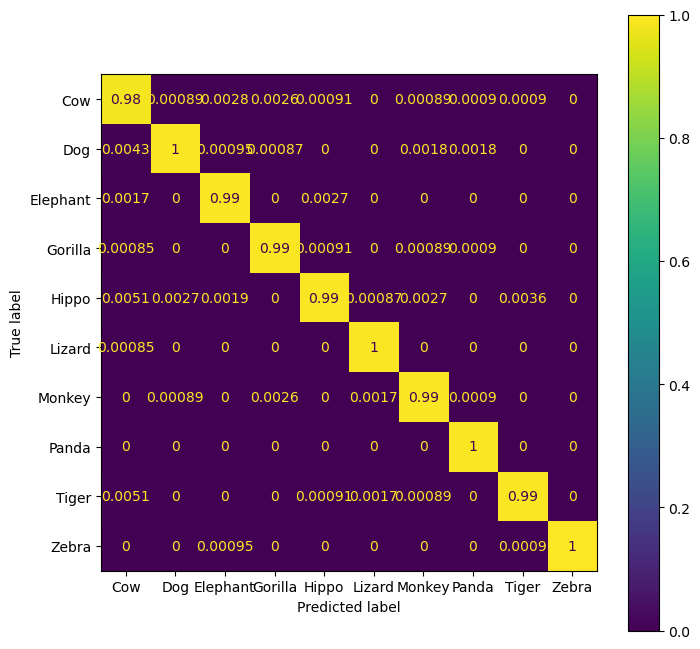

In [107]:
cm = confusion_matrix(true_labels_co, predicted_labels_co, normalize='pred') 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

# Quantification of the model performance

## Classification Metrics

### Accuracy, Precision, Recall, F1


In [128]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

predicted_labels_sc_co = np.array([])
true_labels_sc_co = np.array([])

validation_predicted_labels_sc_co = np.array([])
validation_true_labels_sc_co = np.array([])

for x, y in training_data:
    predicted_labels_sc_co = np.concatenate([predicted_labels_sc_co,
                       np.argmax(complex_opt_model(x), axis=-1)])
    true_labels_sc_co = np.concatenate([true_labels_sc_co, y])

for x, y in validation_data:
    validation_predicted_labels_sc_co = np.concatenate([validation_predicted_labels_sc_co,
                       np.argmax(complex_opt_model(x), axis=-1)])
    validation_true_labels_sc_co = np.concatenate([validation_true_labels_sc_co, y])


In [129]:
print(accuracy_score(true_labels_sc_co,predicted_labels_sc_co))
print(accuracy_score(validation_true_labels_sc_co,validation_predicted_labels_sc_co))

0.9939372325249644
0.7647270114942529


In [141]:
print(precision_score(true_labels_sc_co,predicted_labels_sc_co, average=None))
print(precision_score(validation_true_labels_sc_co,validation_predicted_labels_sc_co, average=None))

print(precision_score(true_labels_sc_co,predicted_labels_sc_co, average='macro'))
print(precision_score(validation_true_labels_sc_co,validation_predicted_labels_sc_co, average='macro'))

[0.98289136 0.9955516  0.99433962 0.99391833 0.99546279 0.99568594
 0.99116608 0.99638009 0.99460432 1.        ]
[0.64285714 0.83690987 0.76656151 0.76226415 0.77777778 0.6809816
 0.67844523 0.84246575 0.79553903 0.90458015]
0.9940000131940385
0.76883822213462


In [142]:
print(recall_score(true_labels_sc_co,predicted_labels_sc_co, average=None))
print(recall_score(validation_true_labels_sc_co,validation_predicted_labels_sc_co, average=None))

print(recall_score(true_labels_sc_co,predicted_labels_sc_co, average='macro'))
print(recall_score(validation_true_labels_sc_co,validation_predicted_labels_sc_co, average='macro'))

[0.99222798 0.99026549 0.99621928 0.99651568 0.9838565  0.9991342
 0.99468085 0.99909256 0.99015219 0.99728507]
[0.70522388 0.73584906 0.79153094 0.74814815 0.66315789 0.81617647
 0.67368421 0.92830189 0.7456446  0.84642857]
0.9939429799778562
0.7654145663349897


In [145]:
print(f1_score(true_labels_sc_co,predicted_labels_sc_co, average=None))
print(f1_score(validation_true_labels_sc_co,validation_predicted_labels_sc_co,  average=None))

print(f1_score(true_labels_sc_co,predicted_labels_sc_co, average='macro'))
print(f1_score(validation_true_labels_sc_co,validation_predicted_labels_sc_co,  average='macro'))

[0.9875376  0.99290151 0.99527856 0.99521531 0.98962562 0.99740709
 0.99292035 0.99773448 0.99237326 0.99864069]
[0.67259786 0.78313253 0.77884615 0.75514019 0.71590909 0.74247492
 0.67605634 0.88330341 0.76978417 0.87453875]
0.9939634479131338
0.7651783410156809


In [152]:
from sklearn.model_selection import KFold

x = []
y = []

for image, label in training_data.concatenate(validation_data).unbatch():
    x.append(image.numpy())
    y.append(label.numpy())

x = np.array(x)
y = np.array(y)

In [156]:
# Define the number of splits for cross-validation
nr_of_splits = 4
kf = KFold(n_splits=nr_of_splits, shuffle=True)

val_errors_list = []

final_drop_rate = 0.005
final_l2_value = 0.0000001
        
complex_opt_model_kfold = models.Sequential()
# first
complex_opt_model_kfold.add(layers.Conv2D(96, (6, 6),strides=2, activation='relu' , kernel_regularizer=tf.keras.regularizers.l2(final_l2_value), input_shape=(img_height, img_width, img_channels)))
complex_opt_model_kfold.add(layers.BatchNormalization())
complex_opt_model_kfold.add(layers.Dropout(final_drop_rate))

# second
complex_opt_model_kfold.add(layers.Conv2D(128, (5, 5), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(final_l2_value)))
complex_opt_model_kfold.add(layers.BatchNormalization())
complex_opt_model_kfold.add(layers.Dropout(final_drop_rate))
# third
complex_opt_model_kfold.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
complex_opt_model_kfold.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(final_l2_value)))
complex_opt_model_kfold.add(layers.BatchNormalization())
complex_opt_model_kfold.add(layers.Dropout(final_drop_rate))
#fourth
complex_opt_model_kfold.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(final_l2_value)))
complex_opt_model_kfold.add(layers.BatchNormalization())
complex_opt_model_kfold.add(layers.Dropout(final_drop_rate))
#fifth
complex_opt_model_kfold.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(final_l2_value)))
complex_opt_model_kfold.add(layers.BatchNormalization())
complex_opt_model_kfold.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
complex_opt_model_kfold.add(layers.Dropout(final_drop_rate))
#deep
complex_opt_model_kfold.add(layers.Flatten())
complex_opt_model_kfold.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(final_l2_value)))
complex_opt_model_kfold.add(layers.BatchNormalization())
complex_opt_model_kfold.add(layers.Dropout(final_drop_rate))
complex_opt_model_kfold.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(final_l2_value)))
complex_opt_model_kfold.add(layers.BatchNormalization())
complex_opt_model_kfold.add(layers.Dropout(final_drop_rate))
complex_opt_model_kfold.add(layers.Dense(10))
complex_opt_model_kfold.summary()

complex_opt_model_kfold.compile(optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

for train_index, val_index in kf.split(x):
    # Split data into training and validation sets
    X_train_fold, X_val_fold = x[train_index], x[val_index]
    Y_train_fold, Y_val_fold = y[train_index], y[val_index]
    
    # Train your TensorFlow model on the training data
    complex_opt_model_kfold.fit(X_train_fold, Y_train_fold, epochs=15, batch_size=32)
    
    # Evaluate the model on the validation data
    val_error = complex_opt_model_kfold.evaluate(X_val_fold, Y_val_fold)
    
    # Append the validation error to the list
    val_errors_list.append(val_error)

# Calculate mean and standard deviation of validation errors
val_error_mean = np.mean(val_errors_list)
val_error_std = np.std(val_errors_list)

print(val_errors_list)
print(f'Out-of-sample Root Mean Squared Error using {nr_of_splits}-fold CV:')
print(f'mean: {val_error_mean}\nstandard-deviation: {val_error_std}')

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         (None, 30, 30, 96)        10464     
                                                                 
 batch_normalization_168 (Ba  (None, 30, 30, 96)       384       
 tchNormalization)                                               
                                                                 
 dropout_154 (Dropout)       (None, 30, 30, 96)        0         
                                                                 
 conv2d_121 (Conv2D)         (None, 30, 30, 128)       307328    
                                                                 
 batch_normalization_169 (Ba  (None, 30, 30, 128)      512       
 tchNormalization)                                               
                                                                 
 dropout_155 (Dropout)       (None, 30, 30, 128)     

KeyboardInterrupt: 

u) Finally: evaluate the model performance using the test-set


# Discussion